# Algoritmo de Busca (Grover)

Hoje veremos uma aplicação direta de como um computador quantico pode superar um computador clássico usando um dos principais algoritmos da computação quântica o Algoritmo de Grover.


## Algoritmo Clássico:

Vamos começar com o algoritmo CLÁSSICO de busca. Consideremos um banco de dados não classificado com $N$ entradas. Nosso problema é determinar o índice da ```entrada``` ($x$) do banco de dados que satisfaça algum critério de pesquisa. Para isso definimos a função ```resposta``` ($r(x)$) a função que mapeia as entradas do banco de dados para ```True``` (0) ou ```False``` (1), onde $r(x) = 0$ se e somente se $x$ satisfaz o critério de pesquisa ($x = p$) onde $p$ é o elemento procurado. Para isso vamos criar a subrotina conhecida como Oráculo.

In [1]:
# definindo uma lista de N elementos (N = 19 alunos + 1 Professor)

alunos = ["Adailton","Alinne","Ana Clara","Anna Beatriz","Danielly","Frankle","Gleydson","Hannah","Jherssica","João Pedro","Jonathas","Laisa","Lucas","Maria Heloisa","Taina","Tatiana","Teonas","Thales","Thayne","Clebson"]
print(alunos)

['Adailton', 'Alinne', 'Ana Clara', 'Anna Beatriz', 'Danielly', 'Frankle', 'Gleydson', 'Hannah', 'Jherssica', 'João Pedro', 'Jonathas', 'Laisa', 'Lucas', 'Maria Heloisa', 'Taina', 'Tatiana', 'Teonas', 'Thales', 'Thayne', 'Clebson']


In [2]:
# Vejamos como encontrar o Professor nessa lista usando um algoritmo clássico (Oráculo)

def oraculo(pergunta):
    professor = "Clebson"
    if pergunta is professor:
        resposta = True
    else:
        resposta = False
    return resposta
    

In [3]:
# Vejamos quantas vezes o Oráculo tem qe consultar a lista para encontrar o Professor

for posicao, tentativa in enumerate(alunos):
    if oraculo(tentativa) is True:
        print("O Professor foi encontrado na posição %i."%posicao)
        print("Após %i consultas a lista."%(posicao+1))
        break

O Professor foi encontrado na posição 19.
Após 20 consultas a lista.


Quanto mais distante o meu elemento estiver na lista maior o número de consultas que o Oraculo precisará fazer para encontrar o elemento. Na média a complexidade desse problema requer que o Oráculo consulte a lista $\frac{N}{2}$ vezes. Se o elemento estiver no final da lista o Oráculo precisará consultá-la $N$ vezes. Logo dizemos que o grau de complexidade desse problema é de ordem $\mathcal{O}\left(N\right)$. Vamos ver como fica esse problema em um Cmputador Quântico.

## Algoritmo Quântico:

O Algoritmo de Grover pode acelerar quadraticamente o problema de pesquisa em uma lista não estruturada, entretanto esse é um algoritmo poderoso e sua utilidade vai além desse uso, sendo utilizado como  sub-rotina  para melhorar quadraticamente  a velocidade de execução de uma grande variedade de outros algoritmos, através do que chamamos de processo de amplificação de amplitude. E é lógico que eu vou ensinar esse processo aqui para vocês :-)


### Criando o Oráculo:

Suponha que temos uma lista com N itens. E queremos encontrar um item que vamos chamar de "Procurado" (*p*).
Vamos criar o nosso "Oráculo Quântico", representado pela operação unitária $U_p$:
<math> \begin{cases} 
 U_p \vert x\rangle = -\vert x\rangle & \text{se } x = p, \\
 U_p \vert x\rangle = \vert x\rangle & \text{se } x \ne p.
\end{cases}</math>

$U_p$ é uma matriz diagonal que adiciona uma fase negativa a entrada que corresponde ao item marcado. $U_p$ pode ser codificada em um circuito quântico.

Vamos começar com um exemplo simples de 2 qbits os elementos da lista podem ser codificados na base computacional  como $\lbrace \vert 00\rangle,\vert 01\rangle,\vert 10\rangle,\vert 11\rangle\rbrace$. Seja $\vert p\rangle = \vert 11\rangle$. Temos uma porta que faz exatamente o que queremos, a porta CZ!

In [5]:
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
%matplotlib inline

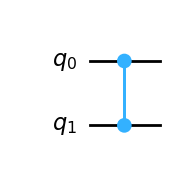

In [6]:
Qr = QuantumRegister(2, 'q')
Cr = ClassicalRegister(2, 'c')

# Definindo a subrotina Oráculo

oraculo = QuantumCircuit(Qr,name = "Oráculo")
oraculo.cz(Qr[0],Qr[1])
oraculo.draw(output = 'mpl')

Vejamos se nosso Oráculo funciona. Para isso precisamos preparar uma sobreposição em todos os qbits através da porta Hadamard. Isso irá permitir que o Oráculo consulte cada um deles simultaneamente.

Vamos criar nosso circuito de busca:

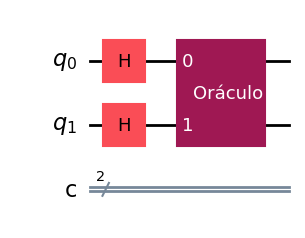

In [7]:
grover = QuantumCircuit(Qr,Cr)
grover.h([Qr[0],Qr[1]])
grover.append(oraculo,[Qr[0],Qr[1]])
grover.draw(output = 'mpl')

Antes do Oráculo $\rightarrow$ $\vert s_{antes} \rangle = \frac{1}{2}\left[ \vert 00\rangle+\vert 01\rangle+\vert 10\rangle+\vert 11\rangle\right]$

Depois do Oráculo $\rightarrow$ $\vert s_{depois} \rangle = \frac{1}{2}\left[ \vert 00\rangle+\vert 01\rangle+\vert 10\rangle-\vert 11\rangle\right]$

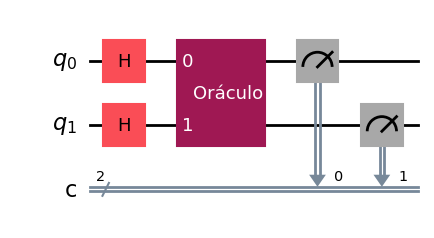

In [12]:
grover.measure(Qr,Cr)
grover.draw(output = 'mpl')

In [13]:
from qiskit_aer import * 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

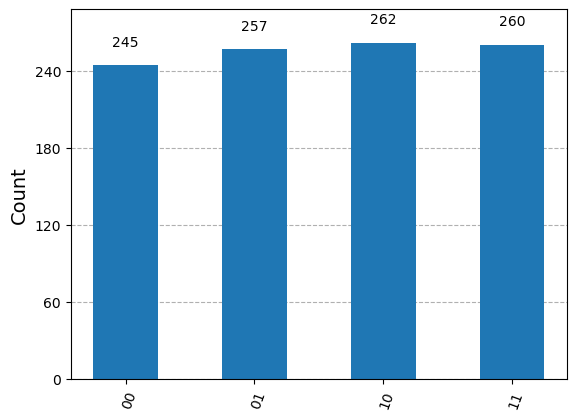

In [16]:
simulador = Aer.get_backend('statevector_simulator') #selecionando o simulador no nosso computador doméstico

pm = generate_preset_pass_manager(optimization_level=0, backend=simulador)

transpile = pm.run(grover)

counts = simulador.run(transpile, shots=1024).result().get_counts()

plot_histogram(counts)


Temos um problema aqui! A fase adicionada pelo Oráculo não muda as Probabilidades!!!

Precisamos amplificar a probablilidade do elemento procurado  $\vert p\rangle$ para aumentar a chance de encontrar ele em uma medida no meu estado sobreposto, e reduzir as probabilidades dos demais estados $\vert x\rangle$ $\forall$ $x \ne p$.

Para isso vamos usar o conhecido Operador de Reflexão. O Oráculo mais o Operador de Reflexão formam o que conhecemos como Amplificação de Amplitude.

Vamos criar nosso circuito de reflexão:

### Criando a reflexão:

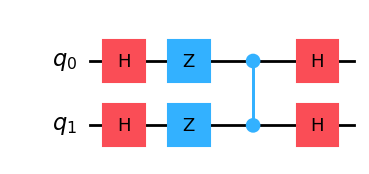

In [17]:
reflexao = QuantumCircuit(Qr,name = "Reflexão")
reflexao.h([Qr[0],Qr[1]])
reflexao.z([Qr[0],Qr[1]])
reflexao.cz(Qr[0],Qr[1])
# Transformando o o estado de volta
reflexao.h([Qr[0],Qr[1]])
reflexao.draw(output = 'mpl')

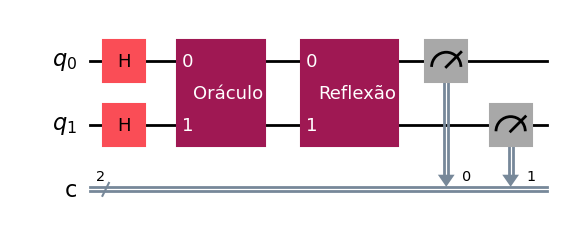

In [18]:
grover = QuantumCircuit(Qr,Cr)
grover.h([Qr[0],Qr[1]])
grover.append(oraculo,[Qr[0],Qr[1]])
grover.append(reflexao,[Qr[0],Qr[1]])
grover.measure(Qr,Cr)
grover.draw(output = 'mpl')

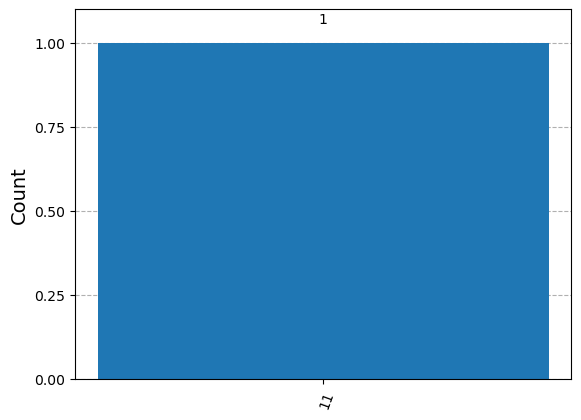

In [23]:
simulador = Aer.get_backend('statevector_simulator') #selecionando o simulador no nosso computador doméstico

pm = generate_preset_pass_manager(optimization_level=0, backend=simulador)

transpile = pm.run(grover)

counts = simulador.run(transpile, shots=1).result().get_counts()

plot_histogram(counts)


In [24]:
print("O estado 11 foi encontrado após %s consultas"%counts)

O estado 11 foi encontrado após {'11': 1} consultas


Ou seja encontramos nosso estado fazendo somente 1 única consulta ao oráculo!

Vejamos isso num computador clássico para vocês verem a potência dessa técnica! 

In [ ]:
lista = ["00","01","10","11"]
print(lista)

In [ ]:
def oraculo(x):
    p = "11"
    if x is p:
        resposta = True
    else:
        resposta = False
    return resposta

for posicao, tentativa in enumerate(lista):
    if oraculo(tentativa) is True:
        print("O estado 11 foi encontrado na posição %i."%posicao)
        print("Após %i consultas a lista."%(posicao+1))
        break

# Vamos fazer essa busca em um computador quântico real?

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [ ]:
comput = provider.get_backend('ibmq_athens')
job = execute(grover, backend=comput)
job_monitor(job)

In [ ]:
resultado = job.result()
plot_histogram(resultado.get_counts(grover))

## Algoritmo de Busca para Três Qbits

### 1. Registrando os Qbits:

In [25]:
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
%matplotlib inline

Qr = QuantumRegister(3, 'q')
Cr = ClassicalRegister(3, 'c')

Os Estados da Base computacional são:

$\lbrace \vert 000\rangle,\vert 001\rangle,\vert 010\rangle,\vert 011\rangle, \vert 100\rangle,\vert 101\rangle,\vert 110\rangle,\vert 111\rangle\rbrace$

### 2. Criando o Oráculo:

Suponha que temos uma lista com 8 itens. E queremos encontrar um item $\vert 111\rangle$ .
Vamos criar o nosso "Oráculo Quântico", representado pela operação unitária $U_p$:
<math> \begin{cases} 
 U_p \vert x\rangle = -\vert x\rangle & \text{se } x = 111, \\
 U_p \vert x\rangle = \vert x\rangle & \text{se } x \ne 111.
\end{cases}</math>

Logo esse Oráculo deve ser a porta CCZ atuando

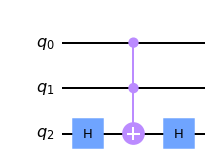

In [26]:
# Definindo a subrotina Oráculo

oraculo = QuantumCircuit(Qr,name = "Oráculo")
oraculo.h(Qr[2])
oraculo.ccx(Qr[0],Qr[1],Qr[2]) 
oraculo.h(Qr[2])
oraculo.draw(output = 'mpl')

### 3. Criando o Circuito de Amplificação:

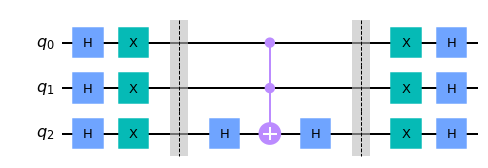

In [27]:
# Definindo a subrotina Amplificação

ampl = QuantumCircuit(Qr,name = "Amplificação")

# Aplicar transformação | s> -> | 00..0> (porta H em todos os qbits)
ampl.h([Qr[0],Qr[1],Qr[2]])
# Aplicar transformação | 00..0> -> | 11..1> (portas X)
ampl.x([Qr[0],Qr[1],Qr[2]])
ampl.barrier()
# Construindo a porta CCZ
ampl.h(Qr[2])
ampl.ccx(Qr[0],Qr[1],Qr[2])
ampl.h(Qr[2])
ampl.barrier()
# Transformando o o estado de volta

# Aplicar transformação | 11..1> -> | 00..0> (portas X)
ampl.x([Qr[0],Qr[1],Qr[2]])
# Aplicar transformação | 00..0> -> | s>  (porta H em todos os qbits)
ampl.h([Qr[0],Qr[1],Qr[2]])
ampl.draw(output = 'mpl')

### 4. Criando o Algoritmo de Busca:

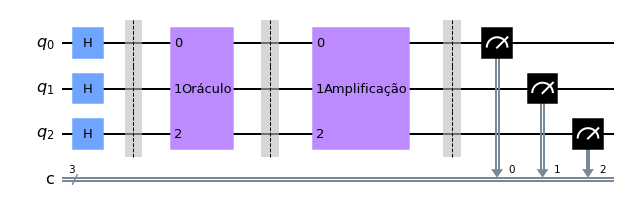

In [28]:
grover = QuantumCircuit(Qr,Cr)
grover.h([Qr[0],Qr[1],Qr[2]])
grover.barrier()
grover.append(oraculo,Qr)
grover.barrier()
grover.append(ampl,Qr)
grover.barrier()
grover.measure(Qr,Cr)
grover.draw(output = 'mpl')

### 5. Simulando:

#### Em nosso Computador

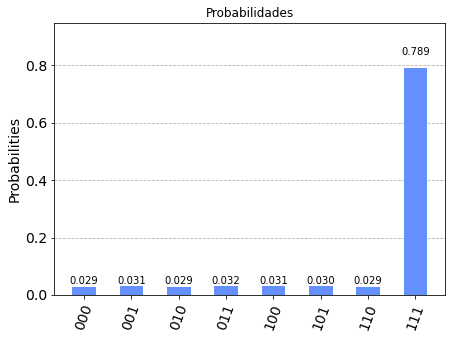

In [33]:
simulador = Aer.get_backend('qasm_simulator')
resultado = execute(grover, backend=simulador, shots=8000).result()
titulo = 'Probabilidades'
plot_histogram(resultado.get_counts(grover),title=titulo)

### In a classical computer:

In [2]:
list = ["000","001","010","011" ,"100","101","110","111"]
print(list)

['000', '001', '010', '011', '100', '101', '110', '111']


In [3]:
def oracle(x):
    p = "111"
    if x is p:
        r = True
    else:
        r = False
    return r

for position, attempt in enumerate(list):
    if oracle(attempt) is True:
        print("Item 111 was found in position %i"%(position+1))
        print("After %i queries"%(position+1))
        break

Item 111 was found in position 8
After 8 queries


#### Na IBM

In [24]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

ibmqfactory.load_account:WARNING:2021-05-26 14:47:03,179: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
comput = provider.get_backend('ibmq_valencia')
job = execute(grover, backend=comput, shots= 8024)
job_monitor(job)

In [ ]:
resultado = job.result()
titulo = 'Probabilidades'
plot_histogram(resultado.get_counts(grover),title=titulo)

## Vamos fazer o mesmo para 4 qbits???

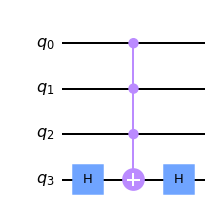

In [17]:
Qr = QuantumRegister(4, 'q')
Cr = ClassicalRegister(4, 'c')
# Definindo a subrotina Oráculo

oraculo = QuantumCircuit(Qr,name = "Oráculo")
oraculo.h(Qr[3])
oraculo.mct([Qr[0],Qr[1],Qr[2]],Qr[3]) 
oraculo.h(Qr[3])
oraculo.draw(output = 'mpl')

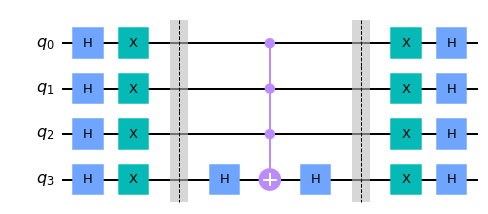

In [18]:
# Definindo a subrotina Amplificação

ampl = QuantumCircuit(Qr,name = "Amplificação")

# Aplicar transformação | s> -> | 00..0> (porta H em todos os qbits)
ampl.h([Qr[0],Qr[1],Qr[2],Qr[3]])
# Aplicar transformação | 00..0> -> | 11..1> (portas X)
ampl.x([Qr[0],Qr[1],Qr[2],Qr[3]])
ampl.barrier()
# Construindo a porta CCZ
ampl.h(Qr[3])
ampl.mct([Qr[0],Qr[1],Qr[2]],Qr[3]) 
ampl.h(Qr[3])
ampl.barrier()
# Transformando o o estado de volta

# Aplicar transformação | 11..1> -> | 00..0> (portas X)
ampl.x([Qr[0],Qr[1],Qr[2],Qr[3]])
# Aplicar transformação | 00..0> -> | s>  (porta H em todos os qbits)
ampl.h([Qr[0],Qr[1],Qr[2],Qr[3]])
ampl.draw(output = 'mpl')

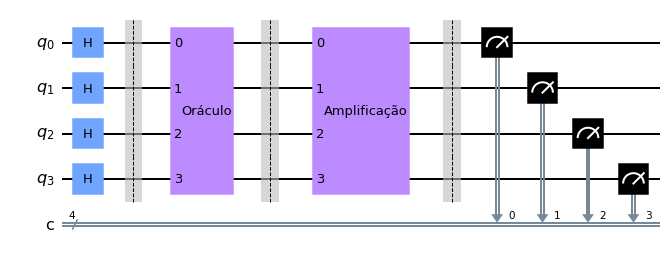

In [19]:
grover = QuantumCircuit(Qr,Cr)
grover.h([Qr[0],Qr[1],Qr[2],Qr[3]])
grover.barrier()
grover.append(oraculo,Qr)
grover.barrier()
grover.append(ampl,Qr)
grover.barrier()
grover.measure(Qr,Cr)
grover.draw(output = 'mpl')

In [30]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

ibmqfactory.load_account:WARNING:2021-05-26 14:48:11,272: Credentials are already in use. The existing account in the session will be replaced.


In [31]:
comput = provider.get_backend('ibmq_belem')
job = execute(grover, backend=comput,shots=8000)
job_monitor(job)

Job Status: job has successfully run


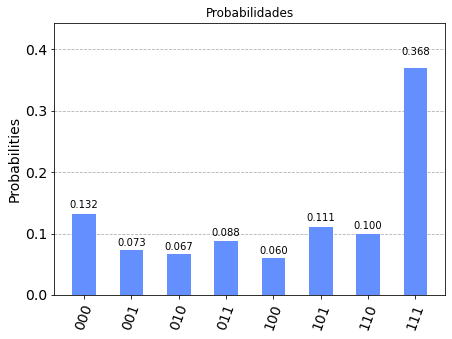

In [32]:
resultado = job.result()
titulo = 'Probabilidades'
plot_histogram(resultado.get_counts(grover),title=titulo)